## CNN using PyTorch
- Reference [hackmd](https://hackmd.io/@lido2370/SJMPbNnKN?type=view)

In [1]:
import os
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
print("Folder contains：")
print(os.listdir("./mnist_revise"))

Folder contains：
['mnist_test.csv', 'mnist_train.csv']


In [3]:
# check GPU
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:1


### loading data

In [4]:
# read train 
train = pd.read_csv("./mnist_revise/mnist_train.csv")
test  = pd.read_csv("./mnist_revise/mnist_test.csv")

In [5]:
X_train = train.drop(labels = ["label"],axis = 1)
Y_train = train["label"]

X_test = test.drop(labels = ["label"],axis = 1)
Y_test = test["label"]


print("Info of training dataset：")
print('# of training samples: {}, Shape: {}'.format(len(train), train.shape))
print('# of training pixels : {}, Shape: {}'.format(len(X_train), X_train.shape))
print('# of classes : {}'.format(len(set(train["label"]))))
print('shape of labels : {}, Shape: {}\n'.format(len(Y_train), Y_train.shape))

print("Info of validation dataset：")
print('# of training samples: {}, Shape: {}'.format(len(test), test.shape))
print('# of training pixels : {}, Shape: {}'.format(len(X_test), X_test.shape))
print('shape of label : {}, Shape: {}'.format(len(Y_test), Y_test.shape))



Info of training dataset：
# of training samples: 60000, Shape: (60000, 785)
# of training pixels : 60000, Shape: (60000, 784)
# of classes : 10
shape of labels : 60000, Shape: (60000,)

Info of validation dataset：
# of training samples: 10000, Shape: (10000, 785)
# of training pixels : 10000, Shape: (10000, 784)
shape of label : 10000, Shape: (10000,)


### Display some img

random_sel index = [31039  7115 27375 12791 17570 51279  6309 51732]
8, 8, 5, 1, 9, 7, 3, 8


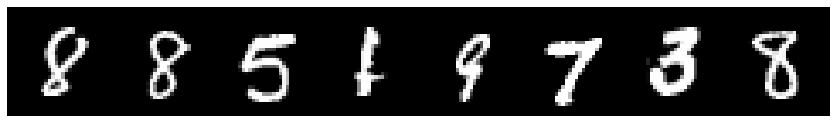

In [6]:
from torchvision.utils import make_grid

random_sel = np.random.randint(len(train), size=8)
print('random_sel index =',random_sel)

grid = make_grid(torch.Tensor((train.iloc[random_sel, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train.iloc[random_sel, 0].values), sep = ', ')

### Histogram of the classes

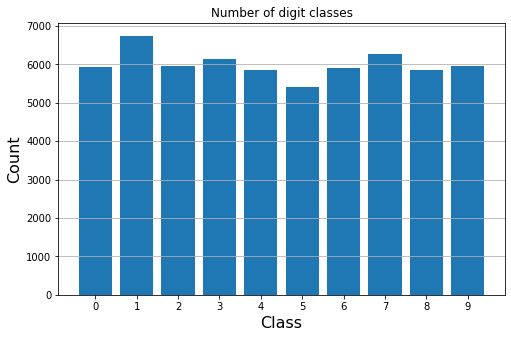

In [7]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train['label'].value_counts().index, train['label'].value_counts())
plt.xticks(np.arange(len(set(train["label"]))))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title("Number of digit classes")
plt.grid('on', axis='y')

In [8]:
# Normalization
## https://blog.csdn.net/qq_40247705/article/details/104756991
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

### Split data

In [9]:
random_state = np.random.randint(200)
img_train, img_val, target_train, target_val = train_test_split(
    X_train, Y_train, test_size = 0.2, random_state = random_state
)

In [10]:
ImgTrain = torch.from_numpy(img_train.values)
TargetTrain = torch.from_numpy(target_train.values).type(torch.LongTensor) 
ImgVal = torch.from_numpy(img_val.values)
TargetVal = torch.from_numpy(target_val.values).type(torch.LongTensor) 
ImgTest = torch.from_numpy(X_test.values)
TargetTest = torch.from_numpy(Y_test.values).type(torch.LongTensor) 

# Pytorch train and test TensorDataset
train = torch.utils.data.TensorDataset(ImgTrain, TargetTrain)
val = torch.utils.data.TensorDataset(ImgVal, TargetVal)
test = torch.utils.data.TensorDataset(ImgTest, TargetTest)

In [11]:
# Hyper Parameters
learning_rate = 0.001
batch_size = 600
n_iters = 10000

num_epochs = int(n_iters / (len(img_train) / batch_size) )

- PyTorch Dataloader data： [LINK](https://pytorch.org/docs/stable/data.html)  
    DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, 
    collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, *, prefetch_factor=2, persistent_workers=False)

In [12]:
# DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [13]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # input_shape=(1,28,28)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) #output_shape=(16,26,26)
        self.batchnormalize1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,13,13)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2) #output_shape=(32,16,16)
        self.batchnormalize2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU() 
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,8,8)
        
        # Fully connected  ,#input_shape=(32*8*8)
        self.fc1 = nn.Linear(32 * 8 * 8, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.batchnormalize1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # Convolution 2
        out = self.cnn2(out)
        out = self.batchnormalize2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        
        # Linear function (readout)
        out = self.fc1(out)
        return out

In [14]:
model = CNN_Model()
print(model)

CNN_Model(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnormalize1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batchnormalize2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # https://blog.csdn.net/KGzhang/article/details/77479737
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
input_shape = (-1, 1, 28, 28)

In [16]:
def train_model(model, loss_func, optimizer, input_shape, epoch, num_epochs, train_loader):
    training_loss = []
    training_accuracy = []
    correct_train = 0
    total_train = 0
    
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(input_shape))
        labels = Variable(labels)
            
        optimizer.zero_grad() # Clear gradients
        outputs = model(train)
        train_loss = loss_func(outputs, labels) # Calculate softmax and cross entropy loss

        train_loss.backward() # Calculate gradients
        optimizer.step()      # Update parameters
            
        # torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)
        predicted = torch.max(outputs.data, 1)[1] # Get predictions from the maximum value
        total_train += len(labels) # Total number of labels
        correct_train += (predicted == labels).float().sum() # Total correct predictions   
        
    train_accuracy = 100 * correct_train / float(total_train)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss.data)
    print('Epoch: [{}/{}]'.format(epoch+1, num_epochs))
    print(' Train --> Loss: {} Acc: {:.6f}% '.format(train_loss.data, train_accuracy))

    return training_loss, training_accuracy
    
def evaluate(model, loss_func, input_shape, val_loader, test_loader, mode):
    loss = []
    accuracy = []  
    
    if mode == 'validation':
        correct_val = 0
        total_val = 0
        for images, labels in val_loader:
            
            val = Variable(images.view(input_shape))
            outputs = model(val)

            val_loss = loss_func(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]

            total_val += len(labels)

            correct_val += (predicted == labels).float().sum()
            
        val_accuracy = 100 * correct_val / float(total_val)
        accuracy.append(val_accuracy)
        loss.append(val_loss.data)
        print(' Val   --> Loss: {} Acc: {:.6f}%'.format(val_loss.data, val_accuracy))
        return loss, accuracy, _

    elif mode == 'testing':
        correct_test = 0
        total_test = 0
        conf_matrix = np.zeros((10, 10))
        class_correct = [0]*10
        class_total   = [0]*10
        
        for images, labels in test_loader:
            test = Variable(images.view(input_shape))
            outputs = model(test)
            test_loss = loss_func(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]

            total_test += len(labels)
            correct_test += (predicted == labels).float().sum()         
            
            correct_tensor = predicted.eq(labels.data.view_as(predicted)) # compare, return Tensor(True, True,....)
            correct = np.squeeze(correct_tensor.numpy()) # return (True, True,....)
        
            for i in range(labels.size(0)):
                label = labels.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
                # Update confusion matrix
                conf_matrix[label][predicted.data[i]] += 1
        
        test_accuracy = 100 * correct_test / float(total_test)
        accuracy.append(test_accuracy)
        loss.append(test_loss.data)
        print(' Test result --> Loss: {} Acc: {:.6f}%'.format(test_loss.data, test_accuracy))
        
        print('Accuracy of each digits')
        for i in range(10):
            if class_total[i] > 0:
                print('Test Accuracy of {}: {}, [{}/{}]' .format(
                    i, 100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]), np.sum(class_total[i]))
                     )
            else:
                print('Test Accuracy of {}: N/A (no training examples)' .format(classes[i]))

        return loss, accuracy, conf_matrix
    else:
        print("WTFFFFFFFFFFF R U kidding me?")
        return None

def fit(model, loss_func, optimizer, input_shape, num_epochs, train_loader, val_loader, test_loader):    
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    for epoch in range(num_epochs):
        
        train_loss_per_epoch, training_accur_per_epoch = train_model(
            model, loss_func, optimizer, input_shape, epoch,  num_epochs, train_loader
        )
        training_loss.append(train_loss_per_epoch)
        training_accuracy.append(training_accur_per_epoch)
        
        mode = 'validation'
        val_loss_per_epoch, val_accur_per_epoch,_ = evaluate(
            model, loss_func, input_shape, val_loader, test_loader, mode
        )
        validation_loss.append(val_loss_per_epoch)
        validation_accuracy.append(val_accur_per_epoch)
    
    print("Now TESTING!!")
    mode = 'testing'
    print(" Mode：", mode)
    test_loss, test_accur, conf_matrix = evaluate(
            model, loss_func, input_shape, val_loader, test_loader, mode
        )
          
    return training_loss, training_accuracy, validation_loss, validation_accuracy, test_loss, test_accur, conf_matrix

In [17]:
training_loss, training_accuracy, validation_loss, validation_accuracy, test_loss, test_accur, conf_matrix = fit(
    model, loss_func, optimizer, input_shape, num_epochs, train_loader, val_loader, test_loader
)

Epoch: [1/125]
 Train --> Loss: 0.16168174147605896 Acc: 87.689583% 
 Val   --> Loss: 0.12336911261081696 Acc: 95.866669%
Epoch: [2/125]
 Train --> Loss: 0.102415069937706 Acc: 97.139580% 
 Val   --> Loss: 0.0806620717048645 Acc: 97.441666%
Epoch: [3/125]
 Train --> Loss: 0.10808651149272919 Acc: 97.941666% 
 Val   --> Loss: 0.10115066170692444 Acc: 97.824997%
Epoch: [4/125]
 Train --> Loss: 0.042416173964738846 Acc: 98.383331% 
 Val   --> Loss: 0.06822509318590164 Acc: 97.974998%
Epoch: [5/125]
 Train --> Loss: 0.051823586225509644 Acc: 98.737503% 
 Val   --> Loss: 0.0560491569340229 Acc: 98.183334%
Epoch: [6/125]
 Train --> Loss: 0.044913049787282944 Acc: 98.841667% 
 Val   --> Loss: 0.04714915156364441 Acc: 98.183334%
Epoch: [7/125]
 Train --> Loss: 0.030962584540247917 Acc: 98.993752% 
 Val   --> Loss: 0.06799104809761047 Acc: 98.150002%
Epoch: [8/125]
 Train --> Loss: 0.034532688558101654 Acc: 99.097916% 
 Val   --> Loss: 0.04448284953832626 Acc: 98.400002%
Epoch: [9/125]
 Train -

Epoch: [67/125]
 Train --> Loss: 0.00016198917001020163 Acc: 100.000000% 
 Val   --> Loss: 0.028807951137423515 Acc: 98.608330%
Epoch: [68/125]
 Train --> Loss: 0.00012604241783265024 Acc: 100.000000% 
 Val   --> Loss: 0.14962968230247498 Acc: 98.566666%
Epoch: [69/125]
 Train --> Loss: 0.00014141782594379038 Acc: 100.000000% 
 Val   --> Loss: 0.058745238929986954 Acc: 98.516670%
Epoch: [70/125]
 Train --> Loss: 0.00012177957978565246 Acc: 100.000000% 
 Val   --> Loss: 0.050835538655519485 Acc: 98.583336%
Epoch: [71/125]
 Train --> Loss: 0.00020006735576316714 Acc: 100.000000% 
 Val   --> Loss: 0.02945166826248169 Acc: 98.516670%
Epoch: [72/125]
 Train --> Loss: 0.00019171179155819118 Acc: 100.000000% 
 Val   --> Loss: 0.1536644846200943 Acc: 98.483330%
Epoch: [73/125]
 Train --> Loss: 0.0001680846617091447 Acc: 100.000000% 
 Val   --> Loss: 0.05873711407184601 Acc: 98.550003%
Epoch: [74/125]
 Train --> Loss: 0.00011504130088724196 Acc: 100.000000% 
 Val   --> Loss: 0.06478811055421829

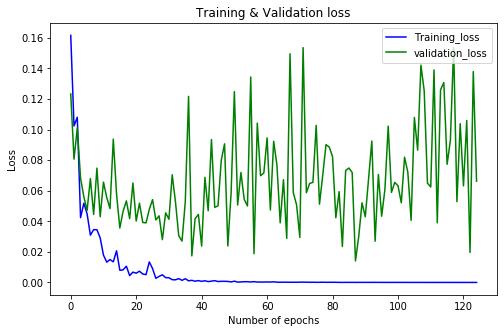

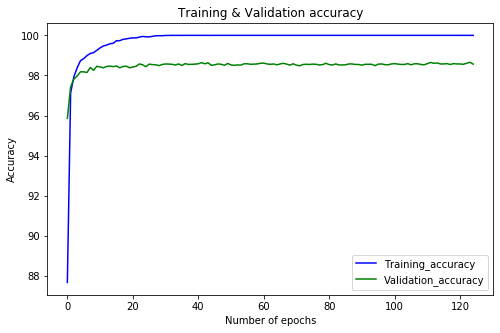

In [18]:
# visualization
plt.plot(training_loss, 'b-', label='Training_loss')
plt.plot(validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(training_accuracy, 'b-', label='Training_accuracy')
plt.plot(validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

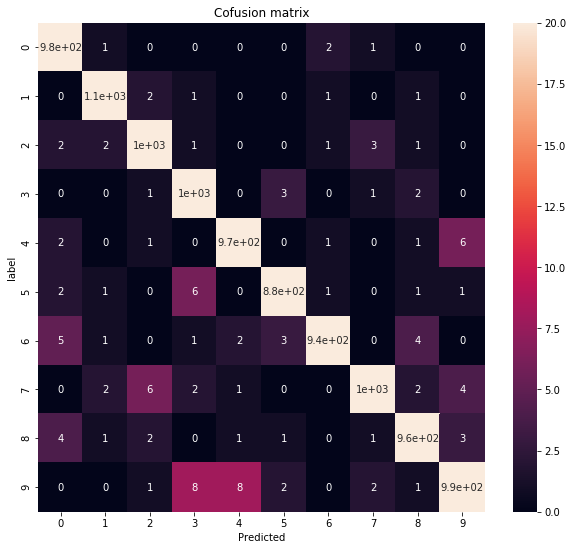

In [19]:
import seaborn as sns
plt.subplots(figsize=(10, 9))
plt.title('Cofusion matrix')
ax = sns.heatmap(conf_matrix, annot=True, vmax=20)
ax.set_xlabel('Predicted');
ax.set_ylabel('label');